<a href="https://colab.research.google.com/github/SubhamZap/Deep-Q-Learning/blob/main/Deep_Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gymnasium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 16.8 MB/s eta 0:00:00


In [2]:
import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
import math
import random
from collections import namedtuple, deque
from itertools import count

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make('CartPole-v1')

In [4]:
is_python = "inline" in matplotlib.get_backend()
if is_python:
  from IPython import display

In [5]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
device

device(type='cuda')

In [7]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
  def __init__(self, capacity):
    self.memory = deque([], maxlen=capacity)

  def push(self, *args):
    self.memory.append(Transition(*args))
  
  def sample(self, batch_size):
    return random.sample(self.memory, batch_size)
  
  def __len__(self):
    return len(self.memory)

In [8]:
class DQN(nn.Module):

  def __init__(self, n_obs, n_actions):
    super(DQN, self).__init__()
    self.layer_1 = nn.Linear(n_obs, 128)
    self.layer_2 = nn.Linear(128, 128)
    self.layer_3 = nn.Linear(128, n_actions)

  def forward(self, x):
    x = F.relu(self.layer_1(x))
    x = F.relu(self.layer_2(x))
    return self.layer_3(x)

In [9]:
batch_size = 128
gamma = 0.99
eps_start = 0.9
eps_end = 0.05
eps_decay = 1000
tau = 0.005
lr = 1e-5

In [10]:
n_actions = env.action_space.n
state, info = env.reset()
n_obs = len(state)

In [33]:
policy_net = DQN(n_obs, n_actions).to(device)
target_net = DQN(n_obs, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=lr, amsgrad = True)
memory = ReplayMemory(1000)

steps_done = 0

def select_action(state):
  global steps_done
  sample = random.random()
  eps_threshold = eps_end + (eps_start - eps_end) * math.exp(-1. * steps_done/eps_decay)
  steps_done += 1
  if sample > eps_threshold:
    with torch.no_grad():
      return policy_net(state).max(1)[1].view(1,1)
  else:
    return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

episode_durations = []

def plot_durations(show_results = False):
  plt.figure(1)
  durations_t = torch.tensor(episode_durations, dtype=torch.float)
  if show_results:
    plt.title("Results")
  else:
    plt.clf()
    plt.title("Training...")

  plt.xlabel('Episodes')
  plt.ylabel('Durations')
  plt.plot(durations_t.numpy())

  if len(durations_t) >= 100:
    means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(99), means))
    plt.plot(means.numpy())

  plt.pause(0.001)
  if is_python:
    if not show_results:
      display.display(plt.gcf())
      display.clear_output(wait=True)
    else:
      display.display(plt.gcf())

In [31]:
def optimize_model():
  if len(memory) < batch_size:
    return
  transitions = memory.sample(batch_size)
  batch = Transition(*zip(*transitions))
  non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
  non_final_next_states = torch.cat([s for s in batch.next_state
                                     if s is not None])
  state_batch = torch.cat(batch.state)
  action_batch = torch.cat(batch.action)
  reward_batch = torch.cat(batch.reward)

  state_action_values = policy_net(state_batch).gather(1, action_batch)
  next_state_values = torch.zeros(batch_size, device=device)
  
  with torch.no_grad():
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

  expected_state_action_value = (next_state_values * gamma) + reward_batch
  criterion = nn.SmoothL1Loss()
  loss = criterion(state_action_values, expected_state_action_value.unsqueeze(1))

  optimizer.zero_grad()
  loss.backward()

  torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
  optimizer.step()

Complete


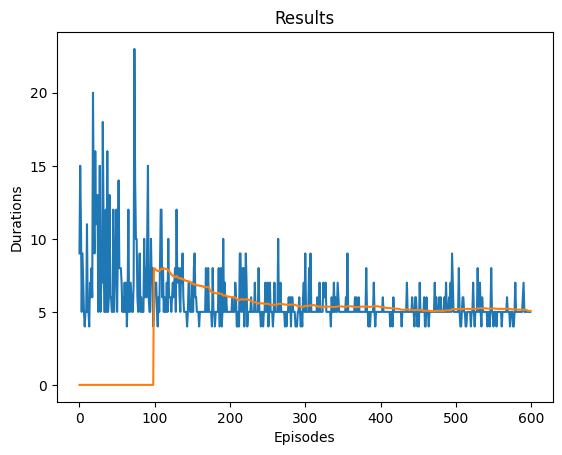

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [34]:
if torch.cuda.is_available():
  num_episodes = 600
else:
  num_episodes = 50

for i_episodes in range(num_episodes):
  state, info = env.reset()
  state = torch.tensor(state, dtype=torch.float, device=device).unsqueeze(0)

  for t in count():
    action = select_action(state)
    print("action: ", action)
    print("action items: ", action.item())
    print("env.step(action.item()): ", env.step(action.item()))
    obs, reward, terminated, truncated, _ = env.step(action.item())
    reward = torch.tensor([reward], device=device)
    done = terminated or truncated

    if terminated:
      next_state = None
    else:
      next_state = torch.tensor(obs, dtype=torch.float, device=device).unsqueeze(0)
    
    memory.push(state, action, next_state, reward)
    state = next_state
    optimize_model()

    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()

    for key in target_net_state_dict:
      target_net_state_dict[key] = policy_net_state_dict[key]*tau + target_net_state_dict[key]*(1-tau)

    target_net.load_state_dict(target_net_state_dict)

    if done:
      episode_durations.append(t+1)
      plot_durations()
      break
    
  print("Complete")
  plot_durations(show_results=True)
  plt.ioff()
  plt.show()